# Through silicon via

A through-silicon via (TSV) consists of one or more vertical signal vias that cuts through the main silicon layer in a wafer. They provide an alternative to traditional wire-bond layouts and allow the creation of densely packaged 3D integrated circuits. 

In this notebook, we simulate the vertical transition of a CPW-connected TSV and characterize its insertion and return loss characteristics. 

<center><img src="img/tsv_render.png" width=640 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
from tidy3d import web

td.config.logging.level = "ERROR"

## Building the Simulation

### Key Parameters

Important geometry dimensions are defined below. 

In [2]:
# Geometry dimensions
len_inf = 1e5  # Effective infinity
R_TSV = 5  # TSV radius
P_TSV = 20  # TSV pitch
G = 7  # CPW gap
WS = 10  # CPW signal width
WG = 100  # CPW ground width
W_CPW = WS + 2 * (G + WG)  # CPW full span
H = 100  # Silicon thickness
TL = 2  # SiO2 liner thickness
TM = 3  # Metal thickness

# Simulation dimensions
sim_LX, sim_LY, sim_LZ = (600, 300, 400)

We will perform a wideband sweep of 1-30 GHz. 

In [3]:
# Frequencies and bandwidth
(f_min, f_max) = (1e9, 30e9)
f0 = (f_min + f_max) / 2
freqs = np.linspace(f_min, f_max, 101)

### Medium and Structures

The TSV comprises of two dielectric material types, silicon and silicon dioxide. The silicon dioxide layer encases the main silicon substrate as well as the vertical vias. 

In [4]:
med_Si = td.Medium(permittivity=11.7)
med_SiO2 = td.Medium(permittivity=3.9)
med_metal = rf.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max))

The simulation geometry is defined below. We start with the dielectric layers.

In [5]:
# Dielectric layers
geom_sub = td.Box.from_bounds(
    rmin=(-len_inf / 2, -len_inf / 2, -H), rmax=(len_inf / 2, len_inf / 2, 0)
)
geom_liner = td.Box.from_bounds(
    rmin=(-len_inf / 2, -len_inf / 2, -H - TL), rmax=(len_inf / 2, len_inf / 2, TL)
)

For the TSV, we define a custom function.

In [6]:
# Create TSV geometry
def create_TSV_cylinders(xpos, ypos):
    """Create TSV cylinders for Si, SiO2, and metal layers at given x, y positions"""
    cyl_sub = td.Cylinder(center=(xpos, ypos, -H / 2), axis=2, radius=R_TSV + TL, length=H)
    cyl_liner = td.Cylinder(center=(xpos, ypos, -H / 2), axis=2, radius=R_TSV, length=H + 2 * TL)
    cyl_metal = td.Cylinder(
        center=(xpos, ypos, -H / 2), axis=2, radius=R_TSV, length=H + TL * 2 + TM * 2
    )

    return [cyl_sub, cyl_liner, cyl_metal]

The TSVs are created below, along with the SiO2 liner. 

In [7]:
# Cut TSV holes from dielectric and create metal TSV cylinders
geoms_TSV_metal = []
for ypos in [-P_TSV, 0, P_TSV]:
    cyl_sub, cyl_liner, cyl_metal = create_TSV_cylinders(0, ypos)
    geom_sub = geom_sub - cyl_sub
    geom_liner = geom_liner - cyl_liner
    geoms_TSV_metal += [cyl_metal]

The CPW geometry is created below.

In [8]:
# Create CPW geometry
def create_CPW_geometry(x_start, x_end, zpos):
    """Create CPW geometry from start to end x-positions (x_start, x_end) at height zpos (relative to bottom boundary)"""
    sig = td.Box.from_bounds(rmin=(x_start, -WS / 2, zpos), rmax=(x_end, WS / 2, zpos + TM))
    gnd1 = td.Box.from_bounds(
        rmin=(x_start, WS / 2 + G, zpos), rmax=(x_end, WS / 2 + G + WG, zpos + TM)
    )
    gnd2 = td.Box.from_bounds(
        rmin=(x_start, -WS / 2 - G - WG, zpos), rmax=(x_end, -WS / 2 - G, zpos + TM)
    )

    return [sig, gnd1, gnd2]

Finally, the geometry of all metallic structures are collected into a single `GeometryGroup` to facilitate processing. 

In [9]:
# Collect CPW geometries (including TSV ) into a single GeometryGroup
geom_CPW_TSV = td.GeometryGroup(
    geometries=create_CPW_geometry(-len_inf / 2, 0, -H - TL - TM)
    + create_CPW_geometry(0, len_inf / 2, TL)
    + geoms_TSV_metal
)

The `Structure` instances are defined below, ready for simulation. 

In [10]:
# Create structures
str_sub = td.Structure(geometry=geom_sub, medium=med_Si)
str_liner = td.Structure(geometry=geom_liner, medium=med_SiO2)
str_CPW_TSV = td.Structure(geometry=geom_CPW_TSV, medium=med_metal)

# Full structure list
str_list_full = [str_liner, str_sub, str_CPW_TSV]

### Grid and Boundaries

For accurate results, the grid should be more refined along the path of the signal, i.e. along the CPW signal trace and vertical vias. To this end, we use the `LayerRefinementSpec` to refine the metallic corners/edges in the top and bottom CPWs, and the `MeshOverrideStructure` to enforce a maximum cross-sectional grid size in the region occupied by each TSV. 

In [11]:
# Parameter settings from LayerRefinementSpec
lr_params = {
    "axis": 2,
    "min_steps_along_axis": 2,
    "corner_refinement": td.GridRefinement(dl=TM / 2, num_cells=2),
}

# Create layer refinement for top and bottom layers
lr1 = rf.LayerRefinementSpec(center=(0, 0, TL + TM / 2), size=(len_inf, W_CPW, TM), **lr_params)
lr2 = rf.LayerRefinementSpec(
    center=(0, 0, -H - TL - TM / 2), size=(len_inf, W_CPW, TM), **lr_params
)

In [12]:
# Refine box around signal TSVs
refine_box = td.MeshOverrideStructure(
    geometry=td.Box.from_bounds(
        rmin=(-R_TSV - TL, -WS / 2 - TL, -H - TL - TM), rmax=(R_TSV + TL, WS / 2 + TL, TL + TM)
    ),
    dl=(R_TSV / 6, R_TSV / 6, None),
)
refine_box2 = refine_box.updated_copy(geometry=refine_box.geometry.translated(0, P_TSV, 0))

The overall grid specification is defined below. 

In [13]:
grid_spec = td.GridSpec.auto(
    wavelength=td.C_0 / f_max,
    min_steps_per_sim_size=75,
    layer_refinement_specs=[lr1, lr2],
    override_structures=[refine_box, refine_box2],
)

### Monitors

For visualization purposes, we define several field monitors below. 

In [14]:
# Field monitors
mon_1 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(0, len_inf, len_inf),
    freqs=[f_min, f0, f_max],
    name="TSV x-plane",
)
mon_2 = td.FieldMonitor(
    center=(0, (WS + G) / 2, 0),
    size=(len_inf, 0, len_inf),
    freqs=[f_min, f0, f_max],
    name="TSV y-plane",
)
mon_3 = td.FieldMonitor(
    center=(0, 0, TL),
    size=(len_inf, len_inf, 0),
    freqs=[f_min, f0, f_max],
    name="TSV z-plane upper",
)
mon_4 = td.FieldMonitor(
    center=(0, 0, -H - TL),
    size=(len_inf, len_inf, 0),
    freqs=[f_min, f0, f_max],
    name="TSV z-plane lower",
)

# Full list of monitors
monitor_list = [mon_1, mon_2, mon_3, mon_4]

### Ports

The excitation for this model will be generated by `WavePort` instances connected to the CPW on each layer. These are defined below. 

In [15]:
# Port dimensions
X0, Y0, Z0 = (-200, 0, -H - TL - TM / 2)  # Port 1 center
X1, Y1, Z1 = (200, 0, TL + TM / 2)  # Port 2 center
w_port, h_port = (W_CPW - 15, 270)  # Port size

In [16]:
# Wave ports
WP1 = rf.WavePort(
    center=(X0, Y0, Z0),
    size=(0, w_port, h_port),
    mode_spec=rf.MicrowaveModeSpec(target_neff=np.sqrt(6)),
    direction="+",
    name="WP1",
    absorber=False,
)
WP2 = WP1.updated_copy(
    center=(X1, Y1, Z1),
    direction="-",
    name="WP2",
)

### Defining Simulation and TerminalComponentModeler

The base `Simulation` object and the `TerminalComponentModeler` are defined below. 

In [17]:
sim = td.Simulation(
    center=(0, 0, -H / 2),
    size=(sim_LX, sim_LY, sim_LZ),
    grid_spec=grid_spec,
    structures=str_list_full,
    monitors=[mon_1, mon_2, mon_3, mon_4],
    run_time=3e-10,
    symmetry=(0, 1, 0),
)

In [18]:
tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=[WP1, WP2],
    freqs=freqs,
)

### Visualization

Before running the simulation, it is a good idea to visualize the simulation domain and grid. The 2D layout of each plane is shown below. 

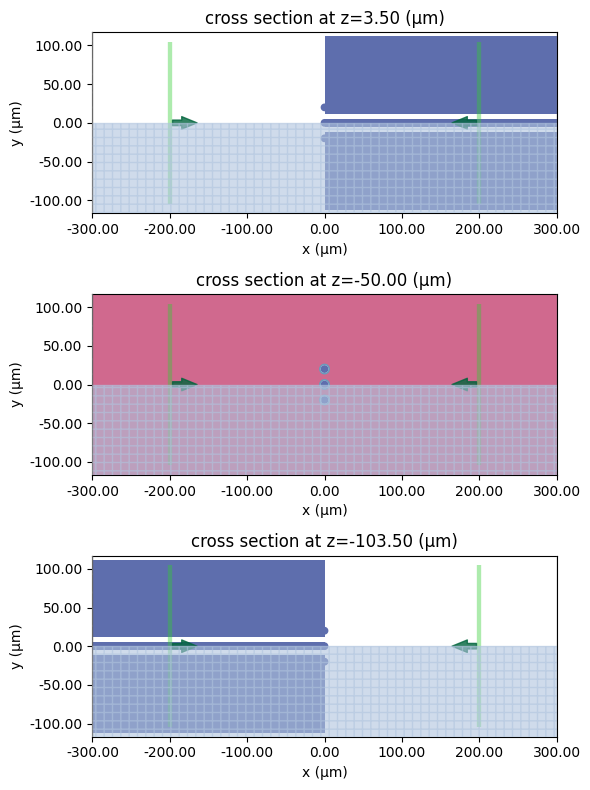

In [19]:
# z-planes upper, mid, and lower
fig, ax = plt.subplots(3, 1, figsize=(8, 8), tight_layout=True)
tcm.plot_sim(z=TL + TM / 2, ax=ax[0], monitor_alpha=0)
tcm.plot_sim(z=-H / 2, ax=ax[1], monitor_alpha=0)
tcm.plot_sim(z=-H - TL - TM / 2, ax=ax[2], monitor_alpha=0)
for axis in ax:
    axis.set_ylim(-WS - G - WG, WS + G + WG)
    axis.set_xlim(-sim_LX / 2, sim_LX / 2)
plt.show()

We check the grid resolution around the TSV structures.

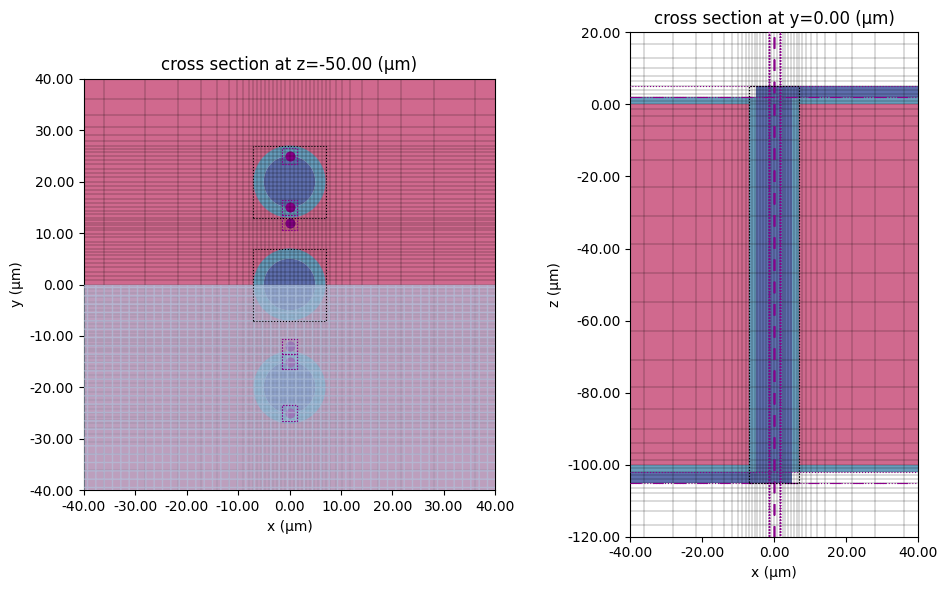

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
tcm.plot_sim(z=-H / 2, ax=ax[0], monitor_alpha=0)
sim.plot_grid(z=-H / 2, ax=ax[0])
ax[0].set_ylim(-40, 40)
ax[0].set_xlim(-40, 40)

tcm.plot_sim(y=0, ax=ax[1], monitor_alpha=0)
sim.plot_grid(y=0, ax=ax[1])
ax[1].set_ylim(-120, 20)
ax[1].set_xlim(-40, 40)
plt.show()

The region around each `WavePort` is shown below. 

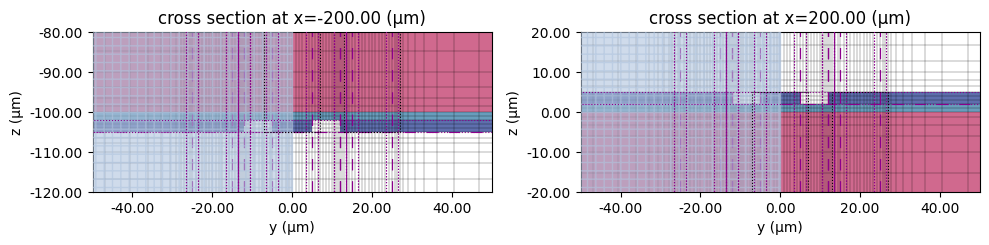

In [21]:
# Grid, CPW ports
fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
sim.plot(x=-200, ax=ax[0], monitor_alpha=0)
sim.plot_grid(x=-200, ax=ax[0], hlim=(-50, 50), vlim=(-120, -80))
sim.plot(x=200, ax=ax[1], monitor_alpha=0)
sim.plot_grid(x=200, ax=ax[1], hlim=(-50, 50), vlim=(-20, 20))
plt.show()

## Running the Simulation

In [22]:
tcm_data = web.run(tcm, task_name="TSV", path="data/tcm_data.hdf5")

17:29:55 EST Created task 'TSV' with resource_id                                
             'sid-53a4c1e5-291f-40b9-9206-d007301989da' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=928596;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=942667;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\taskId]8;;\]8;id=928596;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\=]8;;\]8;id=49118;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\pa]8;;\]8;id=928596;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\-f52fc7d8-8663-4464-9e]8;;\
             ]8;id=928596;https://tidy3d.simulation.cloud/rf?taskId=pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c\7e-2c63954d0d2c']8;;\.

             Task folder: ]8;id=714770;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

17:30:05 EST Maximum FlexCredit cost: 0.243. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

17:30:06 EST Subtasks status - TSV                                              
             Group ID: 'pa-f52fc7d8-8663-4464-9e7e-2c63954d0d2c'

Output()

             Batch status = preprocess

17:30:14 EST Batch status = running

17:32:38 EST Batch status = postprocess

17:33:04 EST Modeler has finished running successfully.

17:33:05 EST Billed flex credit cost: 0.272.

Output()

17:33:11 EST Loading component modeler data from data/tcm_data.hdf5

## Results

### Field Profile

We load the field monitor data and plot the various 2D magnitude profiles below.

In [23]:
# Load simulation data
sim_data = tcm_data.data["WP1@0"]

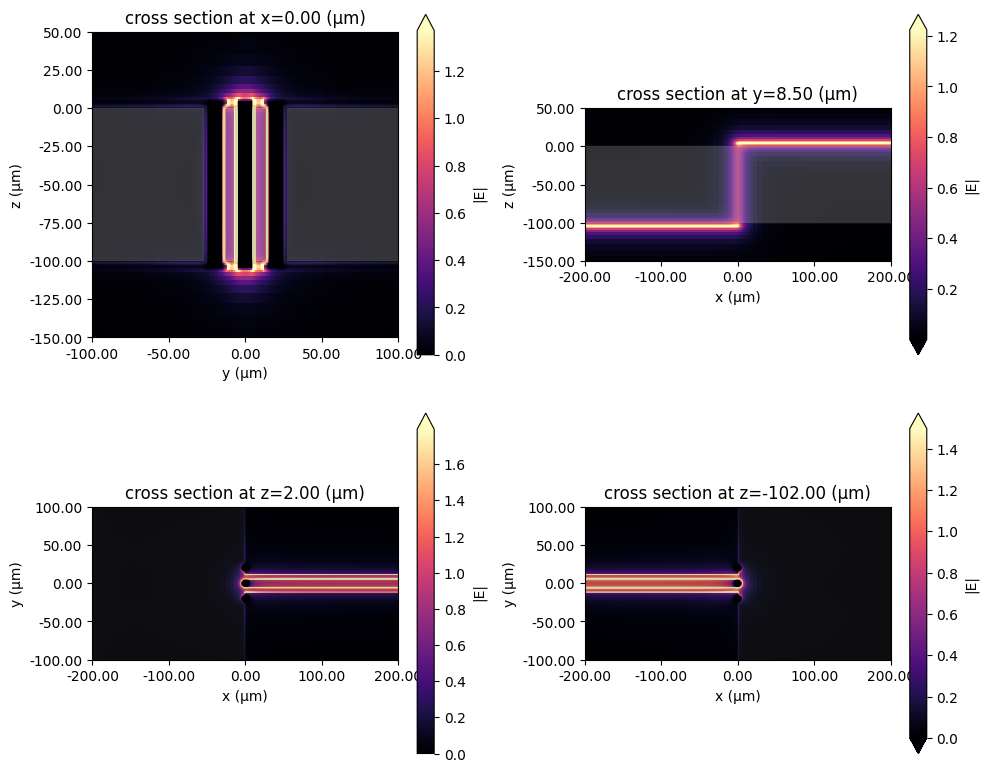

In [24]:
# Field plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
f_plot = f0
sim_data.plot_field("TSV x-plane", "E", val="abs", f=f_plot, ax=ax[0, 0])
ax[0, 0].set_xlim(-100, 100)
ax[0, 0].set_ylim(-150, 50)
sim_data.plot_field("TSV y-plane", "E", val="abs", f=f_plot, ax=ax[0, 1])
ax[0, 1].set_xlim(-200, 200)
ax[0, 1].set_ylim(-150, 50)
sim_data.plot_field("TSV z-plane upper", "E", val="abs", f=f_plot, ax=ax[1, 0])
ax[1, 0].set_xlim(-200, 200)
ax[1, 0].set_ylim(-100, 100)
sim_data.plot_field("TSV z-plane lower", "E", val="abs", f=f_plot, ax=ax[1, 1])
ax[1, 1].set_xlim(-200, 200)
ax[1, 1].set_ylim(-100, 100)
plt.show()

### S-parameters

We calculate the S-matrix and plot the insertion and return losses below. 

In [25]:
# Calculate S-matrix from TCM data
smat = tcm_data.smatrix()


# Convenience functions to access S_ij
def sparam(i, j):
    return np.conjugate(smat.data.isel(port_in=j - 1, port_out=i - 1))


def sparam_abs(i, j):
    return np.abs(sparam(i, j))


def sparam_dB(i, j):
    return 20 * np.log10(sparam_abs(i, j))

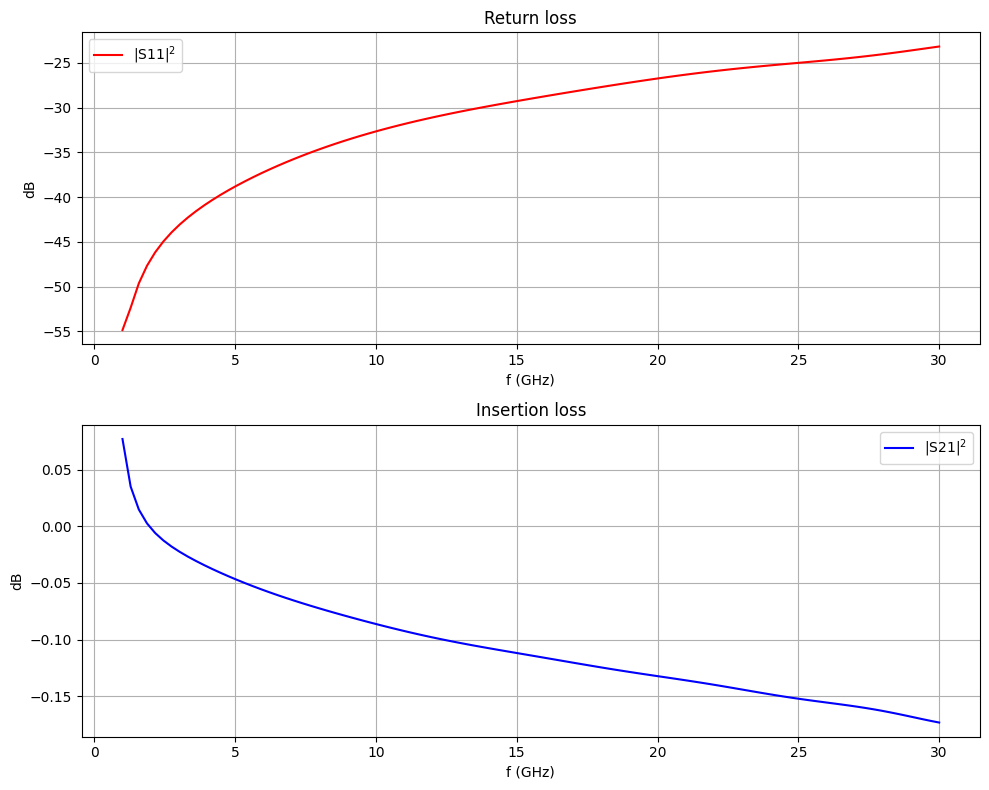

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)
ax[0].plot(freqs / 1e9, sparam_dB(1, 1), "r", label="|S11|$^2$")
ax[0].set_title("Return loss")
ax[1].plot(freqs / 1e9, sparam_dB(1, 2), "b", label="|S21|$^2$")
ax[1].set_title("Insertion loss")
for axis in ax:
    axis.legend()
    axis.grid()
    axis.set_xlabel("f (GHz)")
    axis.set_ylabel("dB")
plt.show()